In [48]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

#### Importing Dataset from Yahoo Finance

**Common Tickers include: ['FB','AMZN','GOOG','TWTR','TSLA']**

In [49]:
import yfinance as yf
stock_symbol = 'GOOG'
data = yf.download(tickers=stock_symbol,period='3y',interval='1d')
data = data.reset_index()
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
753,2022-03-21,2736.949951,2751.649902,2692.229980,2729.570068,2729.570068,1331600
754,2022-03-22,2730.000000,2830.000000,2730.000000,2805.550049,2805.550049,1488800
755,2022-03-23,2782.770020,2800.500000,2763.330078,2770.070068,2770.070068,1265100
756,2022-03-24,2785.449951,2827.929932,2760.788086,2826.239990,2826.239990,1027200
757,2022-03-25,2835.080078,2839.189941,2793.989990,2830.429932,2830.429932,963500


#### Visualizing the Real Stock Trend

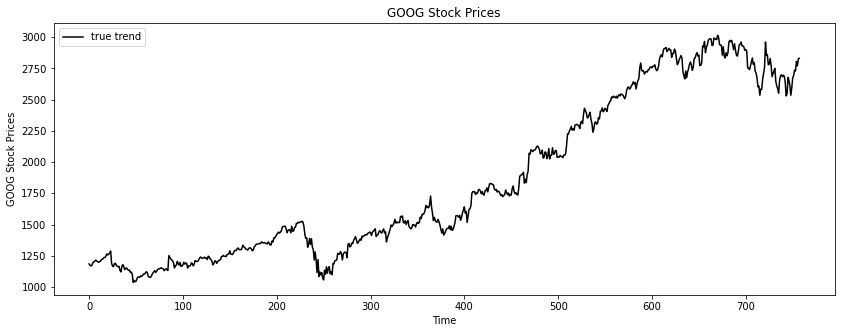

In [50]:
plt.figure(figsize=(14,5))
plt.plot(data['Close'],color='black',label='true trend')
plt.title('%s Stock Prices'%stock_symbol)
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

#### Marking a training timeframe of 60 days

In [51]:
test_size = 60
data_train = data[:-test_size]
data_test = data[-test_size:]
data.shape,data_train.shape,data_test.shape

((758, 7), (698, 7), (60, 7))

#### Preparing the training data

In [52]:
training_data = data_train.drop(['Date','Adj Close'],axis=1)
training_data.head()

,Open,High,Low,Close,Volume
0,1198.530029,1202.829956,1176.719971,1184.619995,1901200
1,1185.500000,1187.558960,1159.369995,1173.020020,1400200
2,1171.540039,1171.564941,1159.431030,1168.489990,961700
3,1174.900024,1178.989990,1162.880005,1173.310059,1269900
4,1184.099976,1196.660034,1182.000000,1194.430054,1252500


In [53]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data[0]

array([0.07871631, 0.07807951, 0.08224111, 0.07502213, 0.26524692])

In [54]:
# Preparing the training set
x_train = []
y_train = []

for i in range(test_size, training_data.shape[0]):
    x_train.append(training_data[i-test_size:i])
    y_train.append(training_data[i,3])
# last 60 days will be the training set - X
# 61st day is the target value - Y

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape,y_train.shape
# 385 rows
# 60 columns
# 5 dimentional data

((638, 60, 5), (638,))

#### Preparaing testing data

In [55]:
past_test_days = data_train.tail(test_size)
df = pd.concat([past_test_days,data_test])
df = df.drop(['Date','Adj Close'],axis='columns')
df.shape, df.head()

((120, 5),
             Open         High          Low        Close   Volume
 638  2680.000000  2747.239990  2680.000000  2723.540039  1206300
 639  2692.510010  2757.040039  2689.729980  2747.080078   988200
 640  2777.260010  2803.089111  2771.260010  2783.709961   912500
 641  2798.120117  2806.340088  2788.586914  2801.120117   946200
 642  2796.000000  2815.272949  2776.129883  2776.949951   829200)

In [56]:
df = scaler.transform(df)
df[0]

array([0.82803095, 0.85435609, 0.83986102, 0.85306004, 0.14666735])

In [57]:
x_test = []
y_test = []

for i in range(test_size,df.shape[0]):
    x_test.append(df[i-test_size:i])
    y_test.append(df[i,3])

x_test, y_test = np.array(x_test),np.array(y_test)
x_test.shape, y_test.shape

((60, 60, 5), (60,))

#### Defining the Scaling Label

In [58]:
# below is the scaling label, 
# therefore we need to divide our y_pred with the below scaling value it used to scale the data
scaler.scale_

array([5.05791317e-04, 5.02636325e-04, 5.03977900e-04, 5.05573965e-04,
       1.70642640e-07])

In [59]:
scale = 1/8.50296711e-04
scale

1176.0600588751424

In [60]:
y_test = y_test*scale

### LSTM - Long Short-Term Memory

In [61]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [62]:
x_train.shape[1],x_train.shape[2]

(60, 5)

In [63]:
regression = Sequential()

# Input layer
regression.add(LSTM(units=40,activation='relu',return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
regression.add(Dropout(0.2))

# 2nd layer (Hidden)
regression.add(LSTM(units=80,activation='relu',return_sequences=True))
regression.add(Dropout(0.2))

# 3rd layer (Hidden)
regression.add(LSTM(units=120,activation='relu'))
regression.add(Dropout(0.3))

# Outer layer
regression.add(Dense(units=1))

regression.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 40)            7360      
                                                                 
 dropout_6 (Dropout)         (None, 60, 40)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 80)            38720     
                                                                 
 dropout_7 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_8 (LSTM)               (None, 120)               96480     
                                                                 
 dropout_8 (Dropout)         (None, 120)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [64]:
regression.compile(optimizer='adam',loss='mean_squared_error',metrics='accuracy')

In [65]:
def forecast():
    regression.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = regression.predict(x_test)
    y_pred = y_pred*scale
    return y_pred

In [66]:
def first_forecast():
    history = regression.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = regression.predict(x_test)
    y_pred = y_pred*scale
    return history,y_pred

In [67]:
result_forecast = []
simulation = 3
print("Simulation 1")
history,first_result = first_forecast()
result_forecast.append(first_result)
for i in range(1,simulation):
    print("Simulation %d"%(i+1))
    result_forecast.append(forecast())


Simulation 1
Epoch 1/300
20/20 [==============================] - 4s 63ms/step - loss: 0.1058 - accuracy: 0.0016
Epoch 2/300
20/20 [==============================] - 1s 63ms/step - loss: 0.0250 - accuracy: 0.0016
Epoch 3/300
20/20 [==============================] - 1s 69ms/step - loss: 0.0081 - accuracy: 0.0016
Epoch 4/300
20/20 [==============================] - 1s 69ms/step - loss: 0.0074 - accuracy: 0.0016
Epoch 5/300
20/20 [==============================] - 1s 62ms/step - loss: 0.0063 - accuracy: 0.0016
Epoch 6/300
20/20 [==============================] - 1s 60ms/step - loss: 0.0056 - accuracy: 0.0016
Epoch 7/300
20/20 [==============================] - 1s 60ms/step - loss: 0.0047 - accuracy: 0.0016
Epoch 8/300
20/20 [==============================] - 1s 59ms/step - loss: 0.0050 - accuracy: 0.0016
Epoch 9/300
20/20 [==============================] - 1s 58ms/step - loss: 0.0046 - accuracy: 0.0016
Epoch 10/300
20/20 [==============================] - 1s 61ms/step - loss: 0.0043 - acc

#### Calculating the Accuracy using MAPE and RMSE

In [68]:
# MAPE - Mean Absolute Percentage Error
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    # mean Absolute Percentage Error - MAPE
    percentage = 1 - np.mean(np.abs((real-predict)/real))
    return percentage * 100
mean_accuracy = []
for i in range(simulation):
    mean_accuracy.append(calculate_accuracy(y_test, result_forecast[i]))

mean_accuracy

[91.29501663962044, 93.91389708380031, 93.5109824466642]

In [69]:
# RMSE - Root Mean Squared Error 
def calculate_rmse(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((y_test - result_forecast[0])/y_test)))
    return percentage * 100
mean_rmse = []
for i in range(simulation):
    mean_rmse.append(calculate_rmse(y_test, result_forecast[i]))

mean_rmse,np.mean(mean_rmse)

([89.7323638256469, 89.7323638256469, 89.7323638256469], 89.73236382564691)

#### Visualization

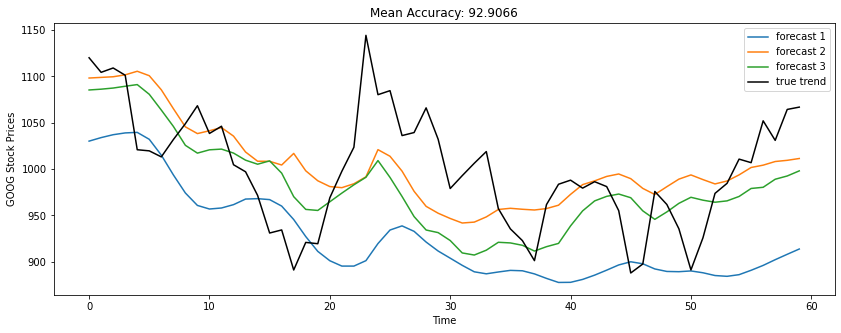

In [70]:
plt.figure(figsize=(14,5))
for i in range(simulation):
    plt.plot(result_forecast[i],label='forecast %d'%(i+1))
plt.plot(y_test,color='black',label='true trend')
plt.title('Mean Accuracy: %.4f'%np.mean(mean_accuracy))
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

In [71]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

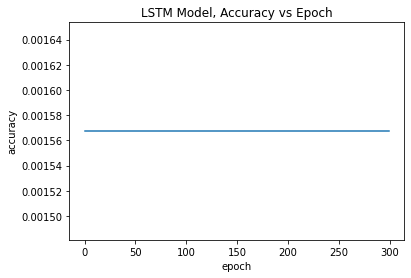

In [72]:
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('LSTM Model, Accuracy vs Epoch')
plt.show()

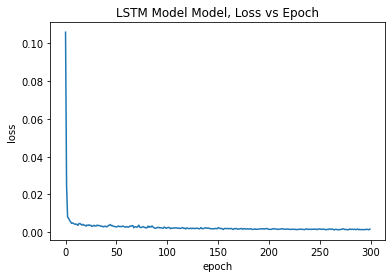

In [73]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('LSTM Model Model, Loss vs Epoch')
plt.show()

In [74]:
present_test_set = data_test
present_test_set = present_test_set.drop(['Date','Adj Close'],axis=1)

#scale the data
present_input = scaler.transform(present_test_set)

# preparing the arrays according to the test_size
present_test = []
present_test.append(present_input)

for i in range(1,test_size):
    a = [0,0,0,0,0]
    ar = []
    for j in range(0,test_size):
        ar.append(a)
    present_test.append(ar)

present_test = np.array(present_test)

y = regression.predict(present_test)
predicted_value = y[0]*scale
print("Next Day's Predicted Closing Index = %f"%predicted_value[0])

Next Day's Predicted Closing Index = 1002.895752


### Final Analysis

>**Dataset:**
>* GOOG
>* 2y  
>
>**Training Timestamp:**
>* 60 days
>  
>**Model:**
>* 4 layers - (1 Input + 2 Hidden + 1 Output)
>* LSTM layers - activation = relu
>* LSTM layers - units = 40,80,120
>* LSTM layers - dropout = 0.2,0.3,0.3
>* Dense layer - units = 1  
>
>**Compile:**
>* optimizer = adam
>
>**Training:**
>* epochs: 250
>* batch_size = 32
>
>**Mean Accuracy:**
>* MAPE - 92.90%
>* RMSE - 89.73%

**Predicted Closing Index for 26th March: 1002.895752**